In [1]:
] activate .

  Activating project at `~/.julia/dev/SpatiotemporalGPs/examples`


In [2]:
# use this command to add the src package into the current environment

In [3]:
# ] dev .. 

In [94]:
] st

Status `~/.julia/dev/SpatiotemporalGPs/examples/Project.toml`
  [91a5bcdd] Plots v1.40.5
  [73b3b457] SpatiotemporalGPs v1.0.0-DEV `..`
  [90137ffa] StaticArrays v1.9.7
  [37e2e46d] LinearAlgebra


In [5]:
using Revise

In [6]:
using SpatiotemporalGPs

Precompiling SpatiotemporalGPs
  ✓ SpatiotemporalGPs
  1 dependency successfully precompiled in 5 seconds. 50 already precompiled.


In [7]:
using StaticArrays, LinearAlgebra, Plots

## Define the Problem

In [45]:
# setup the spatial and temporal kernels
σt = 2.0   # m/s
σs = 1.0   # m/s
lt = 3*60.0  # minutes
ls = 3.0   # km

kt = Matern(3/2, σt, lt)
ks = Matern(1/2, σs, ls)

# determine the temporal step size
Δt = 5.0 # minutes
Δx = 0.25 # km

# create the spatial domain
xs = 0:Δx:7.0
ys = 0:Δx:10.0

grid_pts = vec([@SVector[x, y] for x in xs, y in ys]);

## Create Synthetic Data

In [49]:
# let us generate the synthetic data first
tmax = 4 * 60.0 # minutes
synthetic_data = STGPKF.generate_spatiotemporal_process(xs, ys, Δt, tmax, ks, kt);

In [50]:
@show length(synthetic_data.ts)
@show prod(size(synthetic_data.data));

length(synthetic_data.ts) = 48
prod(size(synthetic_data.data)) = 57072


[ Info: Saved animation to /Users/devanshagrawal/.julia/dev/SpatiotemporalGPs/examples/tmp.gif


Plots.AnimatedGif("/Users/devanshagrawal/.julia/dev/SpatiotemporalGPs/examples/tmp.gif")
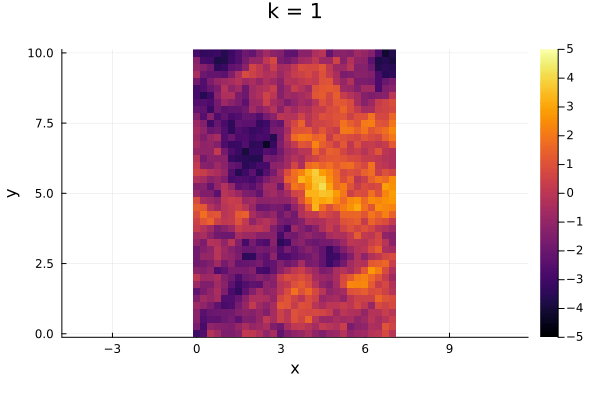

In [51]:
# visualize the ground truth data
@gif for k=1:length(synthetic_data.ts)
    heatmap(synthetic_data.xs, synthetic_data.ys, synthetic_data.data[:, :, k]', clims=(-5,5))
    title!("k = $k")
    xlabel!("x")
    ylabel!("y")
    plot!(aspect_ratio=:equal)
end

## lets start estimating

In [52]:
# create the STGPKF Problem
problem = STGPKFProblem(grid_pts, ks, kt, Δt)

STGPKFProblem{SVector{2, Float64}, Float64, Vector{SVector{2, Float64}}, SpatiotemporalGPs.STGPKF.Matern12{Float64}, SpatiotemporalGPs.STGPKF.Matern32{Float64}, SpatiotemporalGPs.STGPKF.DiscreteTimeStateSpaceModel{SMatrix{2, 2, Float64, 4}, SMatrix{2, 2, Float64, 4}, SMatrix{1, 2, Float64, 2}, Float64}, Symmetric{Float64, Matrix{Float64}}, Symmetric{Float64, Matrix{Float64}}}(SVector{2, Float64}[[0.0, 0.0], [0.25, 0.0], [0.5, 0.0], [0.75, 0.0], [1.0, 0.0], [1.25, 0.0], [1.5, 0.0], [1.75, 0.0], [2.0, 0.0], [2.25, 0.0]  …  [4.75, 10.0], [5.0, 10.0], [5.25, 10.0], [5.5, 10.0], [5.75, 10.0], [6.0, 10.0], [6.25, 10.0], [6.5, 10.0], [6.75, 10.0], [7.0, 10.0]], SpatiotemporalGPs.STGPKF.Matern12{Float64}(1.0, 0.3333333333333333), SpatiotemporalGPs.STGPKF.Matern32{Float64}(4.0, 0.005555555555555556), 5.0, SpatiotemporalGPs.STGPKF.DiscreteTimeStateSpaceModel{SMatrix{2, 2, Float64, 4}, SMatrix{2, 2, Float64, 4}, SMatrix{1, 2, Float64, 2}, Float64}([0.9988790551645961 4.7651327208952186; -0.000441

In [53]:
# construct the state at time 0 conditioned on no measurements
state_initial = stgpkf_initialize(problem) 

KFState{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [529.7095721488881 0.0 … 0.0 0.0; 0.0 5.0971327345413675 … 0.0 0.0; … ; 0.0 0.0 … 529.7095721488881 0.0; 0.0 0.0 … 0.0 5.0971327345413675])

In [54]:
# do some measurements

function rand_point(xs, ys)
    xmin, xmax = extrema(xs)
    ymin, ymax = extrema(ys)
    x = (xmax - xmin) * rand() + xmin
    y = (ymax - ymin) * rand() + ymin
    return @SVector [x, y]
end

function measure(data, x, y, t, σ_m=0.1)
    return data.itp(x, y, t) + σ_m *randn()
end

measure_pt = rand_point(xs, ys)
measure_σ = 0.1 # m/s
measure_y = measure(synthetic_data, measure_pt..., synthetic_data.ts[1], measure_σ)

-1.2093374848259282

In [55]:
# do the correction

state_1_1 = stgpkf_correct(problem, state_initial, measure_pt, measure_y, measure_σ)

KFState{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}([-1.418834759149696, 0.0, -1.356981218269633, 0.0, -1.29685397239794, 0.0, -1.239514513913305, 0.0, -1.184795659754181, 0.0  …  -0.958906074343651, 0.0, -0.8756354243236311, 0.0, -0.7996110212374135, 0.0, -0.7301688584603355, 0.0, -0.6666803195921515, 0.0], [-529.7045059445876 0.0 … 0.0047610263734662725 0.0; 0.0 5.0971327345413675 … 0.0 0.0; … ; 0.0 0.0 … -529.6166421431267 0.0; 0.0 0.0 … 0.0 5.0971327345413675])

In [56]:
# plot the resulting state

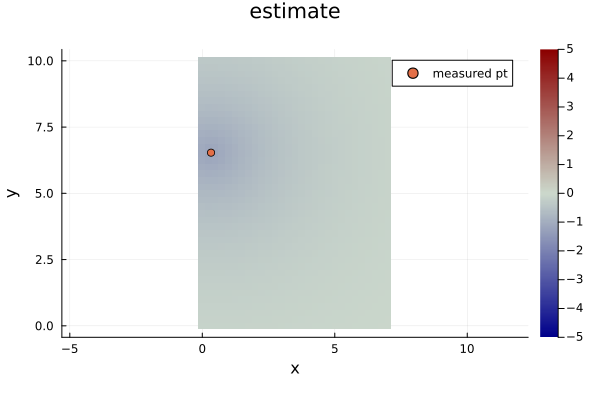

In [75]:
plot(problem, state_1_1; plot_type=:estimate, clims=(-5, 5), cmap=:bluesreds, aspect_ratio=:equal)
scatter!([measure_pt[1]], [measure_pt[2]], label="measured pt")

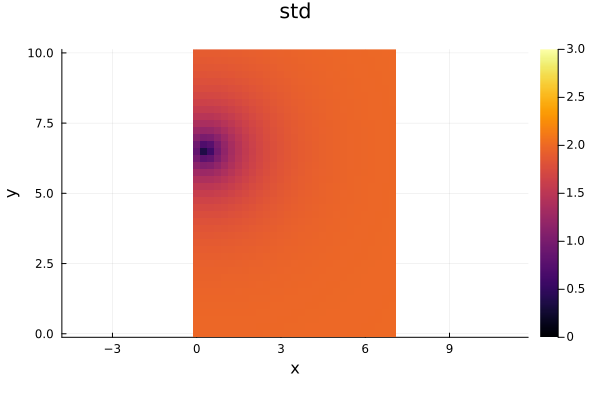

In [58]:
plot(problem, state_1_1; plot_type=:std, clims=(0, 3), aspect_ratio=:equal)

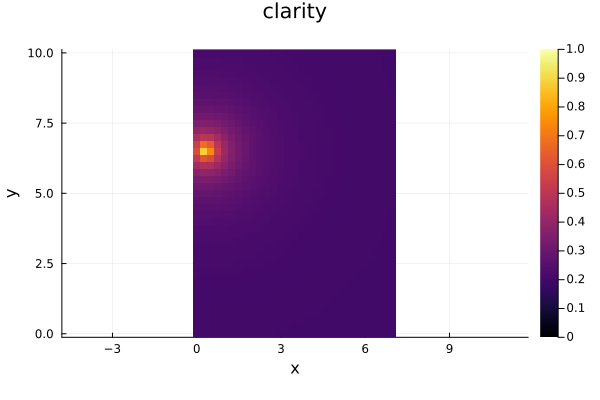

In [59]:
plot(problem, state_1_1; plot_type=:clarity, clims=(0, 1), aspect_ratio=:equal)

In [60]:
# propagate to the next time step

In [61]:
state_2_1 = stgpkf_predict(problem, state_1_1)

KFState{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}([-1.4172443236541354, 0.0006260125867007132, -1.3554601171812735, 0.0005987218152608227, -1.2954002706353074, 0.0005721927127867008, -1.2381250865205258, 0.000546893626691928, -1.1834675691783707, 0.0005227507931360451  …  -0.9578311935319781, 0.0004230846954740847, -0.8746538853170388, 0.00038634435296476885, -0.7987147013928253, 0.00035280117048952227, -0.7293503794494717, 0.00032216217770630136, -0.6659330077310393, 0.0002941500190060595], [529.7045172961471 4.465590703883748e-6 … -0.004750358558129163 2.0982862299020433e-6; 0.0 -5.0971326320462245 … -0.00021806238682673366 9.63205825284709e-8; … ; 0.0 0.0 … 529.6178902417106 8.100084739751101e-5; 0.0 0.0 … 0.0 -5.09713087508909])

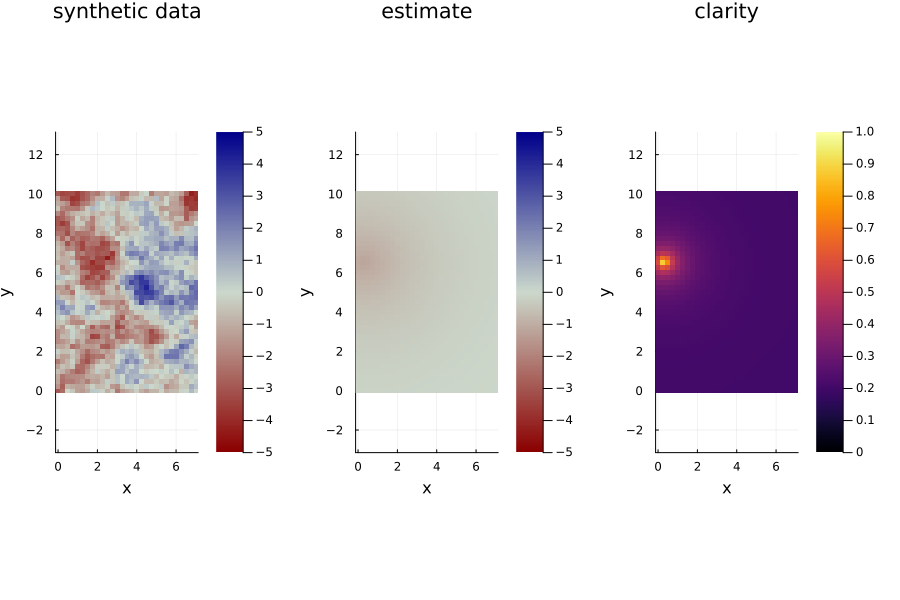

In [62]:
p0 = plot(synthetic_data, synthetic_data.ts[2]; clims=(-5, 5), cmap = :bluesreds, aspect_ratio=:equal)
title!("synthetic data")
p1 = plot(problem, state_2_1; plot_type=:estimate, clims=(-5, 5), cmap=:bluesreds, aspect_ratio=:equal)
p2 = plot(problem, state_2_1; plot_type=:clarity, clims=(0, 1), aspect_ratio=:equal)
plot(p0, p1, p2, layout=(@layout [a b c]), size=(900, 600))

In [63]:
# measure at a 10 different points at the same time
measure_pts = [rand_point(xs, ys) for i=1:10]
measure_ys = [measure(synthetic_data, pt..., synthetic_data.ts[2], measure_σ) for pt in measure_pts]
measure_Σ = (measure_σ^2) * I(10);

In [64]:
# do the KF correction
state_2_2 = stgpkf_correct(problem, state_2_1, measure_pts, measure_ys, measure_Σ)

KFState{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}([-33.707672195731696, 0.0005914755909679558, -36.10161000444035, 0.0005656904462147908, -37.57168459813116, 0.0005406249492949488, -37.53205211242506, 0.0005167216089839904, -36.198555243638026, 0.000493910730978524  …  -164.53933264613937, 0.0003997431930304095, -258.1171802526265, 0.00036502980825248583, -397.2414473947057, 0.00033333719679582997, -296.30707585663066, 0.0003043885514358222, -208.66887405895125, 0.00027792181822068347], [-527.0871293074609 -1.1061897279463612e-7 … 0.0005309802946914207 -5.197750594800004e-8; 0.0 5.097132231127239 … 1.3480759934412384e-5 -4.730872377032186e-7; … ; 0.0 0.0 … -280.477387566097 -4.2896787452412904e-5; 0.0 0.0 … 0.0 5.09713087508909])

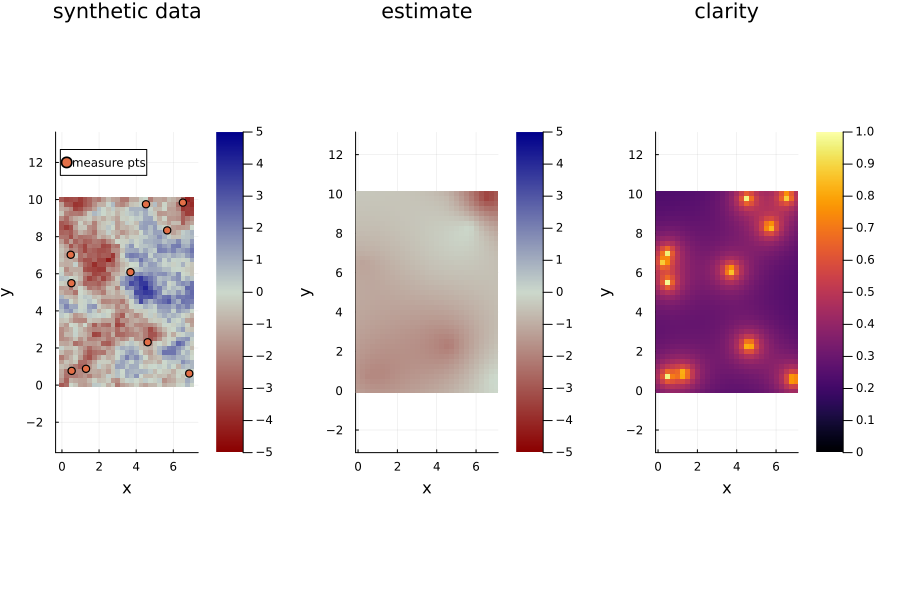

In [65]:
p0 = plot(synthetic_data, synthetic_data.ts[2]; clims=(-5, 5), cmap = :bluesreds, aspect_ratio=:equal)
title!("synthetic data")
scatter!(first.(measure_pts), last.(measure_pts), label="measure pts")
p1 = plot(problem, state_2_2; plot_type=:estimate, clims=(-5, 5), cmap=:bluesreds, aspect_ratio=:equal)
p2 = plot(problem, state_2_2; plot_type=:clarity, clims=(0, 1), aspect_ratio=:equal)
plot(p0, p1, p2, layout=(@layout [a b c]), size=(900, 600))

## Do a whole simulation

In [68]:
# construct the state at time 0 conditioned on no measurements
state = stgpkf_initialize(problem) 

states = (typeof(state))[]

for k=1:length(synthetic_data.ts)

    @show k

    # make some measurements
    measure_pts = [rand_point(xs, ys) for i=1:10]
    measure_ys = [measure(synthetic_data, pt..., synthetic_data.ts[k], measure_σ) for pt in measure_pts]
    measure_Σ = (measure_σ^2) * I(10);

    # do the KF correction
    state_correction = stgpkf_correct(problem, state, measure_pts, measure_ys, measure_Σ)

    # add it to the states
    push!(states, state_correction)

    # do a prediction
    state = stgpkf_predict(problem, state_correction)

end

k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10
k = 11
k = 12
k = 13
k = 14
k = 15
k = 16
k = 17
k = 18
k = 19
k = 20
k = 21
k = 22
k = 23
k = 24
k = 25
k = 26
k = 27
k = 28
k = 29
k = 30
k = 31
k = 32
k = 33
k = 34
k = 35
k = 36
k = 37
k = 38
k = 39
k = 40
k = 41
k = 42
k = 43
k = 44
k = 45
k = 46
k = 47
k = 48


In [69]:
states

48-element Vector{KFState{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}}:
 KFState{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}([-6.777985352249089, 0.0, -7.200988333363411, 0.0, -7.703035661097495, 0.0, -8.2720445068472, 0.0, -8.882344497584926, 0.0  …  -6.9018994781008, 0.0, -6.528407737863031, 0.0, -6.118737122013567, 0.0, -5.685416161306919, 0.0, -5.238217361604488, 0.0], [-529.5035409683617 0.0 … -0.002294277073648089 0.0; 0.0 5.0971327345413675 … 0.0 0.0; … ; 0.0 0.0 … -511.131456909845 0.0; 0.0 0.0 … 0.0 5.0971327345413675])
 KFState{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}([-3.2531051693597246, -0.005620915613872898, -3.558691468544641, -0.005564450310109693, -3.9325074290463964, -0.005435190407500928, -4.364252328070704, -0.005235534321997113, -4.836574469643999, -0.00496838554256506  …  -1.4060756209897551, 0.0036344497738655286, -2.5220280602254483, 0

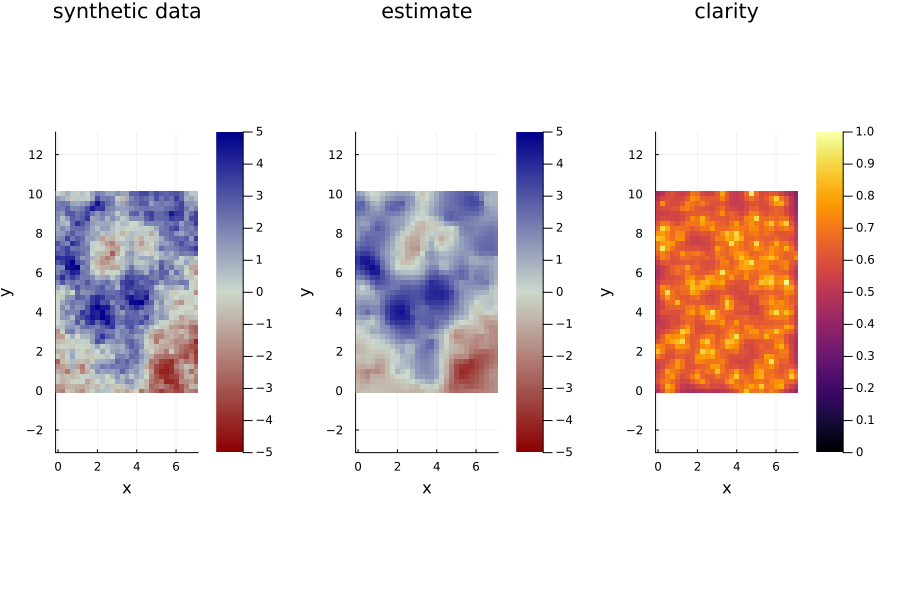

In [70]:
k = 40

p0 = plot(synthetic_data, synthetic_data.ts[k]; clims=(-5, 5), cmap = :bluesreds, aspect_ratio=:equal)
title!("synthetic data")
p1 = plot(problem, states[k]; plot_type=:estimate, clims=(-5, 5), cmap=:bluesreds, aspect_ratio=:equal)
p2 = plot(problem, states[k]; plot_type=:clarity, clims=(0, 1), aspect_ratio=:equal)
plot(p0, p1, p2, layout=(@layout [a b c]), size=(900, 600))

[ Info: Saved animation to /Users/devanshagrawal/.julia/dev/SpatiotemporalGPs/examples/tmp.gif


Plots.AnimatedGif("/Users/devanshagrawal/.julia/dev/SpatiotemporalGPs/examples/tmp.gif")
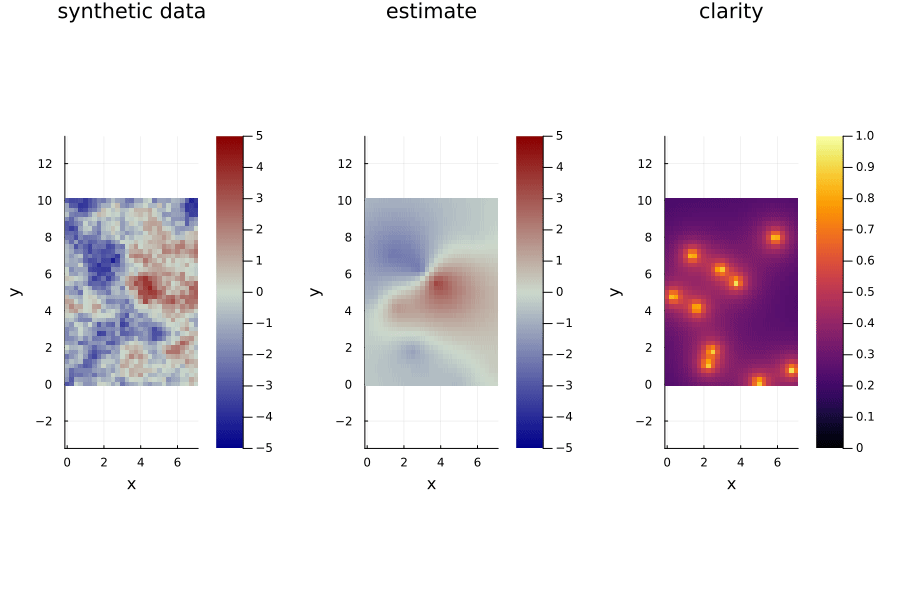

In [76]:
@gif for k=1:length(states)
    p0 = plot(synthetic_data, synthetic_data.ts[k]; clims=(-5, 5), cmap = :bluesreds, aspect_ratio=:equal)
    title!("synthetic data")
    p1 = plot(problem, states[k]; plot_type=:estimate, clims=(-5, 5), cmap=:bluesreds, aspect_ratio=:equal)
    p2 = plot(problem, states[k]; plot_type=:clarity, clims=(0, 1), aspect_ratio=:equal)
    plot(p0, p1, p2, layout=(@layout [a b c]), size=(900, 600))
end

[ Info: Saved animation to /Users/devanshagrawal/.julia/dev/SpatiotemporalGPs/examples/tmp.gif


Plots.AnimatedGif("/Users/devanshagrawal/.julia/dev/SpatiotemporalGPs/examples/tmp.gif")
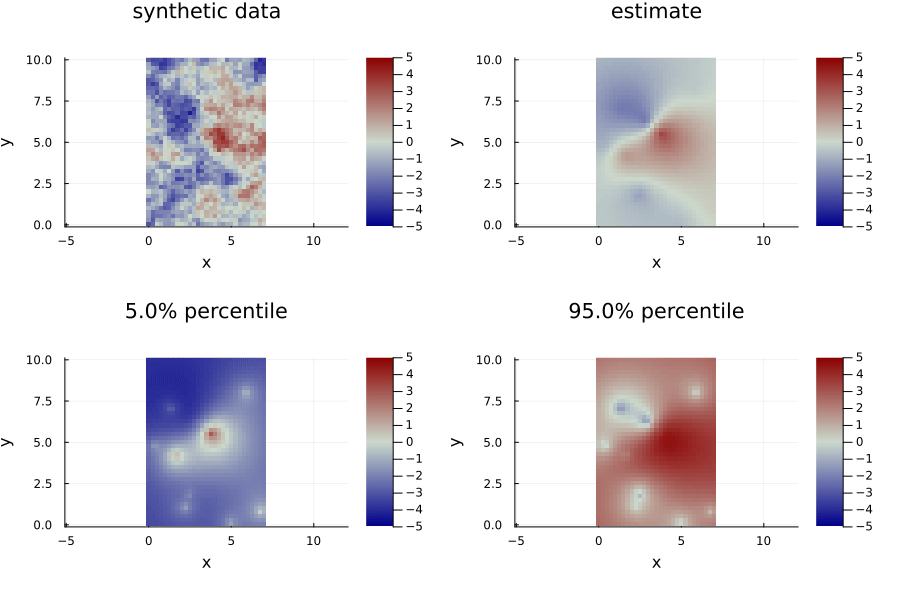

In [77]:
@gif for k=1:length(states)
    p0 = plot(synthetic_data, synthetic_data.ts[k]; clims=(-5, 5), cmap = :bluesreds, aspect_ratio=:equal)
    title!("synthetic data")
    p1 = plot(problem, states[k]; plot_type=:estimate, clims=(-5, 5), cmap=:bluesreds, aspect_ratio=:equal)
    
    p2 = plot(problem, states[k]; plot_type=:percentile, percentile=0.05, clims=(-5, 5), cmap=:bluesreds, aspect_ratio=:equal)

    p3 = plot(problem, states[k]; plot_type=:percentile, percentile=0.95, clims=(-5, 5), cmap=:bluesreds, aspect_ratio=:equal)
    
    plot(p0, p1, p2, p3, layout=(@layout [a b; c d]), size=(900, 600))
end

In [96]:
# check if the data is within the estimate

In [104]:

tol = 0.1

fs = Float64[]
for k=1:length(states)
    M_05 = STGPKF.get_estimate_percentile(problem, states[k], tol/2)
    M_95 = STGPKF.get_estimate_percentile(problem, states[k], (1 - tol/2))
    M_true = vec(synthetic_data.data[:,:, k])
    f = sum(M_05 .<= M_true .<= M_95) / length(M_true)
    push!(fs, f)
end

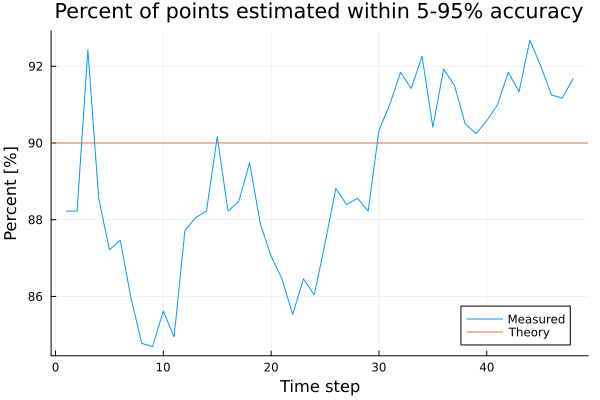

In [105]:
plot(100*fs, label="Measured")
hline!([100*(1 - tol)], label="Theory")
xlabel!("Time step")
title!("Percent of points estimated within tol of accuracy")
ylabel!("Percent [%]")